## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation ... not yet
3. Testing the metric


In [19]:
using PyCall
using DataFrames
using Statistics, Distributions

using Clustering
@pyimport scipy.spatial as sp

using Distances
using Random


import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

cd(wdir)

In [20]:
## Main program

voname = "test.vot"

data       = read_votable(voname)
df         = filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [4.0,5.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

## Votable test.vot read
## Filtering done ...
## Stars selected: 82259
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.39801487608399566, 0.39801487608399566, 0.39801487608399566, 0.4975185951049946, 0.4975185951049946, 0.09950371902099892, 0.09950371902099892, 0.09950371902099892]
##


(GaiaClustering.Df(82259, [369.2086024500513 320.02119012742816 … 622.2456095695549 394.0672899200312; -9.372964447584444 -7.736621602662573 … 6.6651636160074865 2.765046205807492; … ; 0.07490668314678663 0.10261017362788619 … 0.07111385921647513 0.08790177152749785; 0.06331953913931546 0.1065606167267595 … 0.04448238784870664 0.06983127000378304], [147.11591267687353 147.21610997074163 … 152.10123920396188 151.25904246861424; -59.94685644354139 -59.994657954953595 … -60.0970625284319 -60.31419851370228; … ; NaN NaN … NaN NaN; 1.0353000164031982 NaN … 0.49950000643730164 NaN], [0.03525477438230778 0.11011311706236 … 0.055089777092570416 0.08091962141957629; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.39801487608399566, 0.39801487608399566, 0.39801487608399566, 0.4975185951049946, 0.4975185951049946, 0.09950371902099892, 0.09950371902099892, 0.09950371902099892])

In [21]:
## Metric testing...
function _metricHRD(hrdi::GaiaClustering.Df , label)
    
    QA = []
    QP = []
    
    for ilab in label
        nhr = size(ilab)
        points = []
        
        for n in 1:nhr[1]
            push!(points,[hrdi.data[7,ilab[n]],-hrdi.data[6,ilab[n]]])
            
        end
    

  
        ## println("Voronoi tesselation ...")
        ## min_pts is the minimum of pts 
        if length(points) > 4
            per, area = voronoi(points)
            
        else
            per  = [1e10,1e10,1e10,1e10]
            area = [1e10,1e10,1e10,1e10]
        end
        
        p = sort(per ./ nhr[1])
        a = sort(area ./ nhr[1])
        
        n10 = max(1, trunc(Int, nhr[1] / 10))
        start10 = max(1 , 1*n10)
        end10   = min(nhr[1] , 9*n10)
        
        q1a  = mean(a[start10:end10])
        q1p  = mean(p[start10:end10])
        dq1a = std(a[start10:end10])
        dq1p = std(p[start10:end10])
        
        qa  = -log(max(1e-15, q1a))
        dqa = abs(dq1a/qa)   
        qp  = -log(max(1e-15, q1p)) 
        dqp = abs(dq1p / qp)
        
        push!(QA, (qa,dqa))
        push!(QP, (qp,dqp)) 
       
    end
    return(QA,QP)
end


##  proj :
##  spatial2d : y,z (id 2,3)
##  spatial3d : x,y,z (id 1,2,3)
##  velocity  : vrad,vdec (id 4,5)
##  HRD       : Diagram HR (id 6,7)
##
## labels : labels of the clusters##
##
## !!! works with dfcart !!! (cartesian and normalized)

## We add here a probability on the dispersion in space and velocity

function _metric(s::GaiaClustering.Df, labels ,proj = "spatial2d", APERTURE = 1.0 , 
        MAXAPERTURE = 15.0, NBOOTSTRAP = 50 , MAXDISP2D = 8.,  MAXDISP3D = 50. , MAXDISPVEL = 4.)

    ### probabilities of the dispersion..
    p2d  = Normal(0., MAXDISP2D)
    p3d  = Normal(0., MAXDISP3D)
    pvel = Normal(0., MAXDISPVEL)
    
    if proj == "spatial2d"
        ycenter = mean(s.data[2,:])
        zcenter = mean(s.data[3,:]) 
    elseif proj == "spatial3d"
        xcenter = mean(s.data[1,:])      
        ycenter = mean(s.data[2,:])
        zcenter = mean(s.data[3,:]) 
    elseif proj == "velocity"
        vxcenter = mean(s.data[4,:])      
        vycenter = mean(s.data[5,:])
    elseif proj == "HRD"
        res = _metricHRD(s, labels)
        return(res)
    end
    
    aper2 = APERTURE * APERTURE
    Q = []
    for ilab in labels
        slab = s.data[:,ilab]
            
        if proj == "spatial2d"
            yy = slab[2,:]
            zz = slab[3,:]
            ycenter = mean(yy)      
            zcenter = mean(zz)             
            angle_out = 2π * rand(Float64, NBOOTSTRAP)
            rad_out   = (MAXAPERTURE - 2APERTURE) * rand(Float64, NBOOTSTRAP)
            angle_in  = 2π * rand(Float64, NBOOTSTRAP)
            rad_in    = APERTURE * randexp(Float64, NBOOTSTRAP)
            ydisp = std(slab[2,:])
            zdisp = std(slab[3,:])
            prob2d = pdf(p2d,sqrt(ydisp^2+zdisp^2)) / pdf(p2d,0.)
            println("## disp $(sqrt(ydisp^2+zdisp^2))")
            println("## prob2d $prob2d")
        elseif proj == "spatial3d"
            xx = slab[1,:]
            yy = slab[2,:]
            zz = slab[3,:]
            xcenter = mean(xx)             
            ycenter = mean(yy)      
            zcenter = mean(zz)             
            angle_out = 2π * rand(Float64, NBOOTSTRAP)
            phi_out   = π * rand(Float64, NBOOTSTRAP)
            rad_out   = (MAXAPERTURE - 2APERTURE) * rand(Float64, NBOOTSTRAP)
            angle_in  = 2π * rand(Float64, NBOOTSTRAP)
            phi_in    = π * rand(Float64, NBOOTSTRAP)           
            rad_in    = APERTURE * randexp(Float64, NBOOTSTRAP)
            xdisp = std(slab[1,:])
            ydisp = std(slab[2,:])
            zdisp = std(slab[3,:])
            prob3d = pdf(p3d,sqrt(xdisp^2+ydisp^2+zdisp^2)) / pdf(p3d,0.)
            println("## prob3d $prob3d")
        elseif proj == "velocity"
            vx = slab[4,:]
            vy = slab[5,:]   
            vxcenter = mean(vx)      
            vycenter = mean(vy) 
            angle_out = 2π * rand(Float64, NBOOTSTRAP)
            rad_out   = (MAXAPERTURE - 2APERTURE) * rand(Float64, NBOOTSTRAP)
            angle_in  = 2π * rand(Float64, NBOOTSTRAP)
            rad_in    = APERTURE * rand(Float64, NBOOTSTRAP)  
            vxdisp = std(slab[4,:])
            vydisp = std(slab[5,:])
            probvel = pdf(pvel,sqrt(vxdisp^2+vydisp^2)) / pdf(pvel,0.)
            println("## probvel $probvel")
        end  
        
        qc = zeros(NBOOTSTRAP)
            
        for k in 1:NBOOTSTRAP
            if proj == "spatial2d"
                prob =  prob2d
                yout = ycenter + rad_out[k] * cos(angle_out[k])
                zout = zcenter + rad_out[k] * sin(angle_out[k])
                radii_out = (slab[2,:] .- yout) .* (slab[2,:] .- yout) .+ (slab[3,:] .- zout) .* (slab[3,:] .- zout)
                yin = ycenter + rad_in[k] * cos(angle_in[k])
                zin = zcenter + rad_in[k] * sin(angle_in[k])
                radii_in = (slab[2,:] .- yin) .* (slab[2,:] .- yin) .+ (slab[3,:] .- zin) .* (slab[3,:] .- zin)                
            elseif proj == "spatial3d"
                prob = prob3d
                xout = xcenter + rad_out[k] * cos(angle_out[k]) *  cos(phi_out[k])         
                yout = ycenter + rad_out[k] * sin(angle_out[k]) *  cos(phi_out[k])  
                zout = zcenter + rad_out[k] * sin(phi_out[k])
                radii_out = (slab[1,:] .- xout) .* (slab[1,:] .- xout) .+ (slab[2,:] .- yout) .* (slab[2,:] .- yout).+ (slab[3,:] .- zout) .* (slab[3,:] .- zout)
                xin = xcenter + rad_in[k] * cos(angle_in[k]) *  cos(phi_in[k])                  
                yin = ycenter + rad_in[k] * sin(angle_in[k]) *  cos(phi_in[k]) 
                zin = zcenter + rad_in[k] * sin(phi_in[k])
                radii_in = (slab[1,:] .- xin) .* (slab[1,:] .- xin) .+ (slab[2,:] .- yin) .* (slab[2,:] .- yin).+ (slab[3,:] .- zin) .* (slab[3,:] .- zin)              
            elseif proj == "velocity"
                prob = probvel
                vxout = vxcenter + rad_out[k] * cos(angle_out[k])
                vyout = vycenter + rad_out[k] * sin(angle_out[k])
                radii_out = (slab[4,:] .- vxout) .* (slab[4,:] .- vxout) .+ (slab[5,:] .- vyout) .* (slab[5,:] .- vyout)
                vxin = vxcenter + rad_in[k] * cos(angle_in[k])
                vyin = vycenter + rad_in[k] * sin(angle_in[k])
                radii_in = (slab[4,:] .- vxin) .* (slab[4,:] .- vxin) .+ (slab[5,:] .- vyin) .* (slab[5,:] .- vyin)                
            end
            
            isdout = radii_out .< aper2
            nout   = length(radii_out[isdout])
            isin   = radii_in .< aper2 
            nin    = length(radii_in[isin])
         
            qc[k] = prob * (log(max(1,nin)) - log(max(1,nout)))
                
        end
            
        Qc    = mean(qc)
        Q_std = std(qc)    
        #println("Q: $Qc -- Q_std : $Q_std")
        push!(Q,(Qc,Q_std))  
    end
    return(Q)
end

_metric (generic function with 8 methods)

In [22]:
## Clustering ..
println("## Starting Clustering ...")

###########################3
eps = 1.8
min_nei = 10
min_cl = 20

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)
println("## dbscan..")
labels = clusters(dftemp.data , eps , 20, min_nei, min_cl)
println("### done ...")


println("## Computing metric ...")

#### choose the metric
# metric = _metric
metric = GaiaClustering.metric2

println("spatial2d")
q2d = metric(dfcart, labels, "spatial2d" , 1.0 , 20.0, 20 )
#println(q2d)
println("spatial3d")
q3d = metric(dfcart, labels, "spatial3d" , 1.0 , 10.0, 20 )
#println(q3d)
println("velocity")
qv = metric(dfcart, labels, "velocity" , 5.0 , 30.0, 20 )
#println(qv)
println("HRD")
qp, qa = _metric(dfcart, labels, "HRD" )
println(q2d)
println(q3d)
println(qv)
println(qp)
println(qa)


npts = []
nlab = 0
for ilab in labels
    nlab += 1
    println("Label:",nlab," - :",length(ilab))
    push!(npts, length(ilab))
end

indx = labels[1]

## Starting Clustering ...
ϵ : 1.8
## dbscan..
### done ...
## Computing metric ...
spatial2d
spatial3d
velocity
HRD
Any[(2.1698365464598717, 0.9141010967561128), (0.3056598646681409, 0.6465753279411538)]
Any[(-0.06308133841280215, 0.19416026289627805), (0.0, 0.0)]
Any[(3.4348233805072654, 2.4666731883907955), (2.5853314915910532, 1.0613306294739135)]
Any[(10.329532982818325, 8.08118370494551e-6), (3.8253466547362485, 0.009234884936859871)]
Any[(6.723456764338504, 0.00025528759216965276), (1.6393486889026094, 0.14200945489856187)]
Label:1 - :500
Label:2 - :26


500-element Array{Int64,1}:
 53293
 53419
 63767
 63779
 63781
 63790
 63795
 63803
 63804
 63824
 63866
 63870
 63872
     ⋮
 81354
 81369
 81563
 81576
 81633
 81807
 81980
 81992
 82000
 82042
 82135
 82188

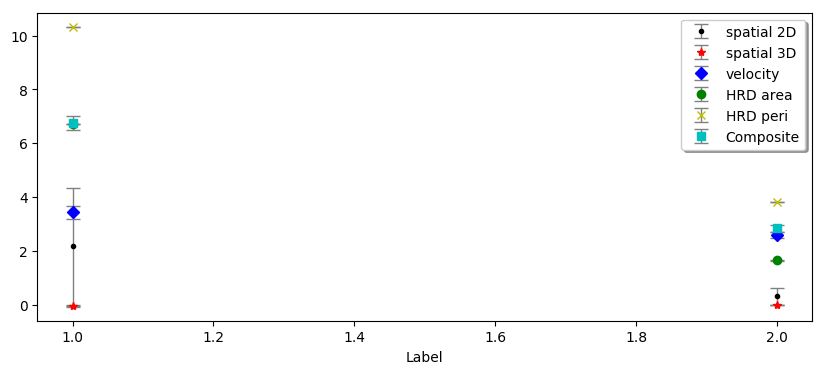

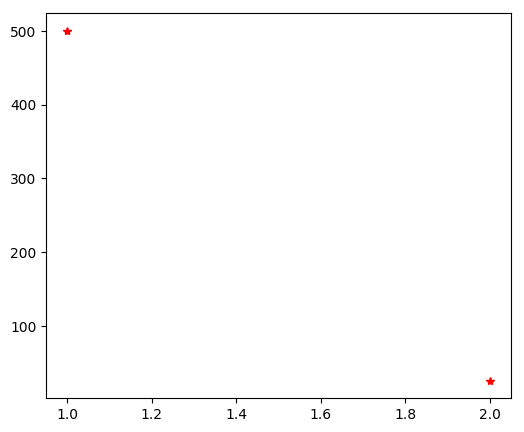

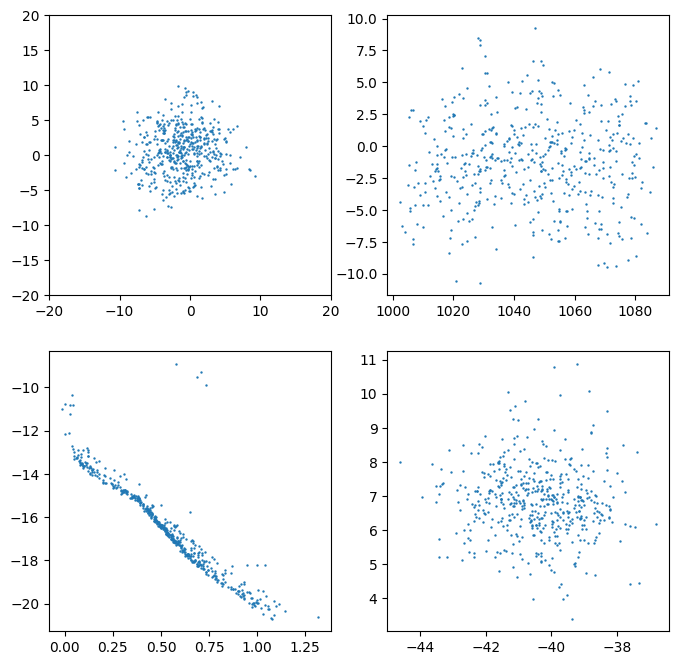

In [23]:
## push Q, Q_st
function pushQ(qc)
    q1  = []
    q1d = []
    for q in qc
        push!(q1,q[1])
        push!(q1d,q[2]/10) 
    end
    return(q1, q1d)
end
    
## metric of the labels
plt.figure(figsize=(10.0,4.0))

xlabel = 1:nlab

qq2d  , qqd2d = pushQ(q2d)
qq3d  , qqd3d = pushQ(q3d)
qqv  , qqdv = pushQ(qv)
qqa  , qqda = pushQ(qa)
qqp  , qqdp = pushQ(qp)


## composite
Qcp = (3.0 .* qq2d .+ qq3d .+ 3.0 .* qqv .+ qqa .+ qqp) ./ 5
Qdcp = (3.0 .* qqd2d .+ qqd3d .+ 4.0 .* qqdv .+ qqda .+ qqdp) ./ 5 


plt.errorbar(xlabel, qq2d, qq2d, label="spatial 2D",fmt=".k", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qq3d, qqd3d, label="spatial 3D",fmt="*r", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqv, qqdv, label="velocity",fmt="Db", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqa, qqda, label="HRD area",fmt="og", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqp, qqdp, label="HRD peri",fmt="xy", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, Qcp, Qdcp, label="Composite",fmt="sc", ecolor="gray", lw=1, capsize=5)
plt.legend(loc="upper right", shadow=true)
plt.xlabel("Label")
plt.show()

plt.figure(figsize=(6.0,5.0))
plt.plot(xlabel, npts,"*r")
plt.show()


plt.figure(figsize=(8.0,8.0))

plt.subplot(2, 2, 1 , xlim = [-20,20] , ylim = [-20,20])
x = dfcart.data[2,indx]
y = dfcart.data[3,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 2)
x = dfcart.data[1,indx]
y = dfcart.data[2,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 3)
x = dfcart.data[7,indx]
y = -dfcart.data[6,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 4)
x = dfcart.data[4,indx]
y = -dfcart.data[5,indx]
plt.scatter(x, y , s = 0.5 )


plt.show()

### Metric of CMD using Voronoi..

In [24]:
## Main program

voname = "testCMD.vot"

data       = read_votable(voname)
df         = filter_data(data)

nhr = size(data.data)
points = []
        
for n in 1:nhr[1]
    push!(points,[data.data[1,n],data.data[2,n]])           
end
            
            

## Votable testCMD.vot read
## Filtering done ...
## Stars selected: 9562


┌ Warning: `getindex(o::PyObject, i1::Integer, i2::Integer)` is deprecated, use `get(o, (i1 - 1, i2 - 1))` instead.
│   caller = top-level scope at In[24]:12
└ @ Core ./In[24]:12


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/stephane/.julia/packages/PyCall/kAhnQ/src/PyCall.jl:761 =# @pysym(:PyObject_GetItem), PyPtr, (PyPtr, PyPtr), o, PyObject(k)))))) <class 'NotImplementedError'>
NotImplementedError('memoryview: unsupported format T{l:solution_id:O:designation:l:source_id:l:random_index:d:ref_epoch:d:ra:d:ra_error:d:dec:d:dec_error:d:parallax:d:parallax_error:f:parallax_over_error:=d:pmra:d:pmra_error:d:pmdec:d:pmdec_error:@f:ra_dec_corr:f:ra_parallax_corr:f:ra_pmra_corr:f:ra_pmdec_corr:f:dec_parallax_corr:f:dec_pmra_corr:f:dec_pmdec_corr:f:parallax_pmra_corr:f:parallax_pmdec_corr:f:pmra_pmdec_corr:i:astrometric_n_obs_al:i:astrometric_n_obs_ac:i:astrometric_n_good_obs_al:i:astrometric_n_bad_obs_al:f:astrometric_gof_al:f:astrometric_chi2_al:=d:astrometric_excess_noise:d:astrometric_excess_noise_sig:@h:astrometric_params_solved:?:astrometric_primary_flag:=f:astrometric_weight_al:d:astrometric_pseudo_colour:d:astrometric_pseudo_colour_error:f:mean_varpi_factor_al:h:astrometric_matched_observations:h:visibility_periods_used:f:astrometric_sigma5d_max:i:frame_rotator_object_type:h:matched_observations:?:duplicated_source:i:phot_g_n_obs:d:phot_g_mean_flux:d:phot_g_mean_flux_error:f:phot_g_mean_flux_over_error:f:phot_g_mean_mag:i:phot_bp_n_obs:d:phot_bp_mean_flux:d:phot_bp_mean_flux_error:f:phot_bp_mean_flux_over_error:f:phot_bp_mean_mag:i:phot_rp_n_obs:d:phot_rp_mean_flux:d:phot_rp_mean_flux_error:f:phot_rp_mean_flux_over_error:f:phot_rp_mean_mag:f:phot_bp_rp_excess_factor:@h:phot_proc_mode:f:bp_rp:f:bp_g:f:g_rp:=d:radial_velocity:d:radial_velocity_error:@i:rv_nb_transits:f:rv_template_teff:f:rv_template_logg:f:rv_template_fe_h:O:phot_variable_flag:=d:l:d:b:d:ecl_lon:d:ecl_lat:q:priam_flags:@f:teff_val:f:teff_percentile_lower:f:teff_percentile_upper:f:a_g_val:f:a_g_percentile_lower:f:a_g_percentile_upper:f:e_bp_min_rp_val:f:e_bp_min_rp_percentile_lower:f:e_bp_min_rp_percentile_upper:l:flame_flags:f:radius_val:f:radius_percentile_lower:f:radius_percentile_upper:f:lum_val:f:lum_percentile_lower:f:lum_percentile_upper:O:datalink_url:O:epoch_photometry_url:}')
